# Optimize Hamiltonian basis with orbital optimization

In this tutorial, we will show how to use the `sqd` package to post-process quantum samples using the [self-consistent configuration recovery technique](https://arxiv.org/abs/2405.05068) and then further optimize the ground state approximation using orbital optimization

Refer to [Sec. II A 4](https://arxiv.org/pdf/2405.05068) for a more detailed discussion on this technique.

### First we will specify the molecule and its properties

In this example, we will approximate the ground state energy of an $N_2$ molecule and then improve the answer using orbital optimization. This guide studies $N_2$ at equilibrium, which is mean-field dominated. This means the MO basis is already a good choice for our integrals; therefore, we will rotate our integrals **out** of the MO basis in order to illustrate the effects of orbital optimization.

In [1]:
import numpy as np
from pyscf import ao2mo, tools
from qiskit_addon_sqd.fermion import rotate_integrals

# Specify molecule properties
num_orbitals = 16
num_elec_a = num_elec_b = 5
open_shell = False
spin_sq = 0

# Read in molecule from disk
mf_as = tools.fcidump.to_scf("../molecules/n2_fci.txt")
hcore = mf_as.get_hcore()
eri = ao2mo.restore(1, mf_as._eri, num_orbitals)

# Rotate our integrals out of MO basis
k_rot = (np.random.rand(num_orbitals**2) - 0.5) * 0.1
hcore_rot, eri_rot = rotate_integrals(hcore, eri, k_rot)

nuclear_repulsion_energy = mf_as.mol.energy_nuc()

Parsing ../molecules/n2_fci.txt


### Generate a dummy counts dictionary and create the bitstring matrix and probability array

In [2]:
from qiskit_addon_sqd.counts import counts_to_arrays, generate_counts_uniform

# Create a seed to control randomness throughout this workflow
rng = np.random.default_rng(24)

# Generate random samples
counts_dict = generate_counts_uniform(10_000, num_orbitals * 2, rand_seed=rng)

# Convert counts into bitstring and probability arrays
bitstring_matrix_full, probs_arr_full = counts_to_arrays(counts_dict)

### Iteratively refine the samples using SQD and approximate the ground state

In [3]:
from qiskit_addon_sqd.configuration_recovery import recover_configurations
from qiskit_addon_sqd.fermion import flip_orbital_occupancies, solve_fermion
from qiskit_addon_sqd.subsampling import postselect_and_subsample

# SQSD options
iterations = 5

# Eigenstate solver options
n_batches = 10
samples_per_batch = 300
max_davidson_cycles = 200

# Self-consistent configuration recovery loop
e_hist = np.zeros((iterations, n_batches))  # energy history
s_hist = np.zeros((iterations, n_batches))  # spin history
occupancy_hist = np.zeros((iterations, 2 * num_orbitals))
occupancies_bitwise = None  # orbital i corresponds to column i in bitstring matrix
for i in range(iterations):
    print(f"Starting configuration recovery iteration {i}")
    # On the first iteration, we have no orbital occupancy information from the
    # solver, so we just post-select from the full bitstring set based on hamming weight.
    if occupancies_bitwise is None:
        bs_mat_tmp = bitstring_matrix_full
        probs_arr_tmp = probs_arr_full

    # In following iterations, we use both the occupancy info and the target hamming
    # weight to refine bitstrings.
    else:
        bs_mat_tmp, probs_arr_tmp = recover_configurations(
            bitstring_matrix_full,
            probs_arr_full,
            occupancies_bitwise,
            num_elec_a,
            num_elec_b,
            rand_seed=rng,
        )

    # Throw out samples with incorrect hamming weight and create batches of subsamples.
    batches = postselect_and_subsample(
        bs_mat_tmp,
        probs_arr_tmp,
        hamming_right=num_elec_a,
        hamming_left=num_elec_b,
        samples_per_batch=samples_per_batch,
        num_batches=n_batches,
        rand_seed=rng,
    )

    # Run eigenstate solvers in a loop. This loop should be parallelized for larger problems.
    int_e = np.zeros(n_batches)
    int_s = np.zeros(n_batches)
    int_occs = np.zeros((n_batches, 2 * num_orbitals))
    cs = []
    for j in range(n_batches):
        energy_sci, coeffs_sci, avg_occs, spin = solve_fermion(
            batches[j],
            hcore_rot,
            eri_rot,
            open_shell=open_shell,
            spin_sq=spin_sq,
            max_davidson=max_davidson_cycles,
        )
        energy_sci += nuclear_repulsion_energy
        int_e[j] = energy_sci
        int_s[j] = spin
        int_occs[j, :num_orbitals] = avg_occs[0]
        int_occs[j, num_orbitals:] = avg_occs[1]
        cs.append(coeffs_sci)

    # Combine batch results
    avg_occupancy = np.mean(int_occs, axis=0)
    # The occupancies from the solver should be flipped to match the bits in the bitstring matrix.
    occupancies_bitwise = flip_orbital_occupancies(avg_occupancy)

    # Track optimization history
    e_hist[i, :] = int_e
    s_hist[i, :] = int_s
    occupancy_hist[i, :] = avg_occupancy

Starting configuration recovery iteration 0
Starting configuration recovery iteration 1
Starting configuration recovery iteration 2
Starting configuration recovery iteration 3
Starting configuration recovery iteration 4


### Visualize the results with no orbital optimization

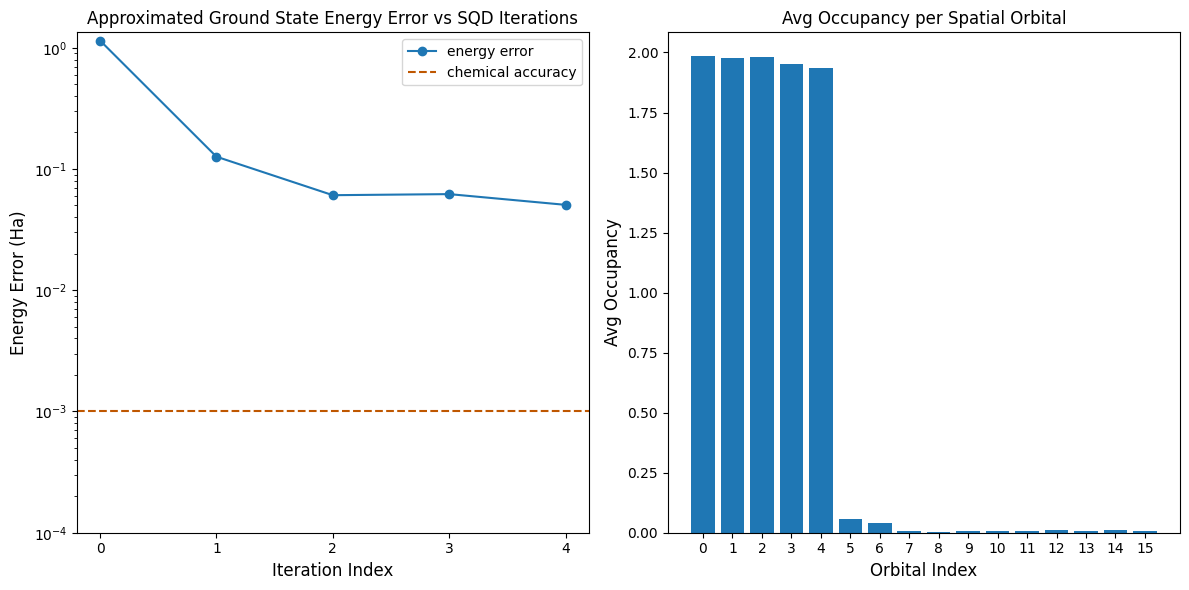

In [4]:
import matplotlib.pyplot as plt

# Data for energies plot
n2_exact = -109.10288938
x1 = range(iterations)
e_diff = [abs(np.min(energies) - n2_exact) for energies in e_hist]
yt1 = [1.0, 1e-1, 1e-2, 1e-3, 1e-4]

# Chemical accuracy (+/- 1 milli-Hartree)
chem_accuracy = 0.001

# Data for avg spatial orbital occupancy
y2 = avg_occupancy[:num_orbitals] + avg_occupancy[num_orbitals:]
x2 = range(len(y2))

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot energies
axs[0].plot(x1, e_diff, label="energy error", marker="o")
axs[0].set_xticks(x1)
axs[0].set_xticklabels(x1)
axs[0].set_yticks(yt1)
axs[0].set_yticklabels(yt1)
axs[0].set_yscale("log")
axs[0].set_ylim(1e-4)
axs[0].axhline(y=chem_accuracy, color="#BF5700", linestyle="--", label="chemical accuracy")
axs[0].set_title("Approximated Ground State Energy Error vs SQD Iterations")
axs[0].set_xlabel("Iteration Index", fontdict={"fontsize": 12})
axs[0].set_ylabel("Energy Error (Ha)", fontdict={"fontsize": 12})
axs[0].legend()

# Plot orbital occupancy
axs[1].bar(x2, y2, width=0.8)
axs[1].set_xticks(x2)
axs[1].set_xticklabels(x2)
axs[1].set_title("Avg Occupancy per Spatial Orbital")
axs[1].set_xlabel("Orbital Index", fontdict={"fontsize": 12})
axs[1].set_ylabel("Avg Occupancy", fontdict={"fontsize": 12})

plt.tight_layout()
plt.show()

### Orbital optimization

We now describe how to optimize the orbitals to further improve the quality of the sqd calculation.

The orbital rotations that are implemented in this package are those described by:
$$
U(\kappa) = e^{\sum_{pq, \sigma} \kappa_{pq} c^\dagger_{p\sigma} c_{q\sigma}},
$$
where $\kappa_{p, q} \in \mathbb{R}$ and $\kappa_{p, q} = -\kappa_{q, p}$. The orbitals are optimized to 
minimize the variational energy:
$$
E(\kappa) = \langle \psi | U^\dagger(\kappa) H U(\kappa)  |\psi \rangle,
$$
with respect to $\kappa$ using gradient descent with momentum. Recall that 
$|\psi\rangle$ is spanned in a subspace defined by determinants.

Since the change of basis alters the Hamiltonian, we allow $|\psi\rangle$ to 
respond to the change in the Hamiltonian. This is done by performing a number of alternating
self-consistent optimizations of $\kappa$ and $|\psi\rangle$. We recall that the optimal
$|\psi\rangle$ is given by the lowest eigenvector of the Hamiltonian projected into the
subspace.

The ``sqd.fermion.fermion`` module provides the tools to perform this alternating
optimization. In particular, the function ``sqd.fermion.optimize_orbitals()``.

Some of the arguments that define the optimization are:

- ``num_iters``: number of self-consistent iterations.
- ``num_steps_grad``: number of gradient step updates performed when optimizing 
$\kappa$ on each self-consistent iteration.
- ``learning_rate``: step-size in the gradient descent optimization of $\kappa$.

#### Setup of the subspace

To define the subspace, we will take the CI strings of the batch with the lowest energy
from the last configuration recovery step. Other strategies may be used, like taking the union 
of the CI strings of the batches in the last configuration recovery iteration.

In [5]:
from qiskit_addon_sqd.fermion import bitstring_matrix_to_ci_strs

best_batch = batches[np.argmin(e_hist[-1])]
ci_strs_up, ci_strs_dn = bitstring_matrix_to_ci_strs(best_batch, open_shell=open_shell)
print(f"Subspace dimension: {len(ci_strs_up) * len(ci_strs_dn)}")
print(f"Energy of that batch from SQD: {e_hist[-1, np.argmin(e_hist[-1])]}")

# Union strategy

# batches_union = np.concatenate((batches[0], batches[1]), axis = 0)
# for i in range(n_batches-2):
#    batches_union = np.concatenate((batches_union, batches[ i+ 2]))
# ci_strs_up, ci_strs_dn = bitstring_matrix_to_ci_strs(
#            batches_union, open_shell=open_shell
#            )
# print (f"Subspace dimension: {len(ci_strs_up) * len(ci_strs_dn)}")

Subspace dimension: 245025
Energy of that batch from SQD: -109.05227474364847


In [6]:
from qiskit_addon_sqd.fermion import optimize_orbitals

k_flat = (np.random.rand(num_orbitals**2) - 0.5) * 0.01  # initial guess for rotation params
num_iters = 10
num_steps_grad = 10_000  # relatively cheap to execute
learning_rate = 0.1

e_improved, k_flat, orbital_occupancies = optimize_orbitals(
    best_batch,
    hcore_rot,
    eri_rot,
    k_flat,
    open_shell=open_shell,
    spin_sq=spin_sq,
    num_iters=num_iters,
    num_steps_grad=num_steps_grad,
    learning_rate=learning_rate,
    max_davidson=max_davidson_cycles,
)

Here we see that by optimizing rotation parameters for our Hamiltonian, we can improve the result from SQD.

In [7]:
print(f"improved_energy in the new basis: {e_improved + nuclear_repulsion_energy}")

improved_energy in the new basis: -109.05255251000438
